 # **Exploración de clusters para el dataset Merchants**

Dado que el *challenge* proporciona el conjunto **merchants;** el cual contiene información agregada de los comercios (merchants_id). El propósito de esta sesión es obtener clusters que agrupen los comercios a partir de caracteristicas evaluadas por diferentes técnicas de *clustering*. 



Según lo anterior esta sesión esta compuesta por dos etapas principales: 

1. Tratamiento de datos
2. Creación de clusters

## **1. Tratamiento de datos**

### **Carga de paquetes**

In [ ]:
#PRS & OSR Se descargar las librerias
import numpy as np
import pandas as pd


# PSR & OSR Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns

#PSR &OSR: Preprocesado y modelado
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.impute import SimpleImputer

import math
from scipy import stats

#PSR &OSR Preprocesamiento
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # Escalamiento estándar
from sklearn.preprocessing import Normalizer, StandardScaler, \
                                  MinMaxScaler, PowerTransformer, \
                                  MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV          # For optimization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV          # For optimization
from sklearn.pipeline import Pipeline                     # For setting up pipeline
from sklearn.compose import ColumnTransformer

from google.colab import files

In [ ]:
# LPS & OSR: Instalando paquetes y creando el ambiente content
!git clone https://github.com/LuisPortela/ELO.git  #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

Cloning into 'ELO'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [ ]:
#LPS &OSR: Se descarga el conjutno de datos desde el API de kaggle
! kaggle competitions download -c elo-merchant-category-recommendation

 99% 610M/615M [00:03<00:00, 163MB/s]
100% 615M/615M [00:03<00:00, 166MB/s]


 ###  **Funciones**

Para el posterior análisis de clusters, se crean inicialmente dos funciones: 
* silhouette_analyisis: la cual tiene el objetivo de entregar el gráfico que permita analizar el correcto agrupamiento de los clusters con respecto a los datos. 
* Plot_dendograma: consiste en una función que grafica un dendógrama para posteriormente ser usado en el método jerarquico. 

In [ ]:
#LPS & OSR: Se crea una función que tiene como objetivo graficar el número de siluetas. 
#clúster a puntos de los clústers vecinos.

def silhouette_analysis(X, range_n_clusters):

    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(19, 4)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters,  max_iter = 300, n_init = 10, random_state=10) 
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d, score = %.3f" % (clusterer.__class__.__name__, n_clusters,silhouette_avg)),
                     fontsize=14, fontweight='bold')

In [ ]:
#LPS & OSR: Se crea una función que tiene como objetivo graficar los dendrogramas. 
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

### **Carga de datos**

In [ ]:
#LPS & OSR: Descomprimiendo el archivo ZIP del dataset train para posteriormente leerlos.
zip_ref = zipfile.ZipFile('elo-merchant-category-recommendation.zip', 'r') # LPS & OSR: este codigo abre el archivo en modo lectura
zip_ref.extractall('/content') #LPS & OSR: este codigo extrae los datos de la carpeta
zip_ref.close()

In [ ]:
#LPS &OSR: Se leen los archivo merchants. 
merchants=pd.read_csv("merchants.csv", sep=",")
merchants.head(2) #LPS& OSR Se realiza la visualización de las dos primeras filas

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0


In [ ]:
#LPS & OSR: Se imprime un resumen de información del dataset merchants
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

Inicialmente se evidencia que el conjunto de datos **Merchants** cuenta incialmente con 334696 registros y 22 caracteristicas. Adicionalmente se puede constatar que el conjunto de datos tiene caracteristicas con datos nulos. 

In [ ]:
stats.mode(merchants['category_2'])[0][0]

1.0

### **Filtrado del dataset Merchants**

En esta etapa se filtran los merchant_id que esten presentes en la base de datos principal obtenido de la sesión **00. creacion_análisis_y_tratamiento_datos.**

In [ ]:
# LPS & OSR:  Leyendo el dataset Merchants_ID proveniente de la sesión 00. creacion_análisis_y_tratamiento_datos
merchant_id=pd.read_csv("ELO/merchant_id_DF.csv", sep=",")
merchant_id.head(2)

,merchant_id
0,M_ID_6b7c68efb4
1,M_ID_0167043535


In [ ]:
#LPS &OSR: Se revisan las dimensiones del dataset merchants_id
merchant_id.shape

(62404, 1)

In [ ]:
#LPS &OSR: Se revisan las dimensiones del dataset merchants
merchants.shape

(334696, 22)

In [ ]:
# Se realiza un merge con un inner join con el objetivo de filtrar los merchant_id presentes en el dataset principal obtenido como resultado de la sesión 00. creacion_análisis_y_tratamiento_datos.
merchants=merchants.merge(merchant_id , how='inner' ,on='merchant_id')

In [ ]:
#LPS &OSR: Se revisan las dimensiones del dataset merchants una vez se filtraron los datos. 
merchants.shape

(62440, 22)

In [ ]:
#LPS &OSR: Se imprime el nombre de las columnas del conjunto de datos merchants
merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [ ]:
#LPS &OSR: se crea una lista con el nombre de las columnas. 
columns=['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2']

### **Imputación de datos**

Debido a que inicialmente se evidenció que algunas características presentan registros con datos nulos, se realizará un proceso de imputación de datos. La imputación de datos se realizará a traves del algoritmo **SimpleImputer** y  se elaborará en dos etapas:

1. Imputación de datos para las variables númericas a partir de la estrategia de la mediana. 
2. Imputación de datos para las variables categóricas a partir de la estrategia *most frecuent*.

In [ ]:
#LPS &OSR: Inicialmente se eliminan todos los registros que contengan datos etiquetados como inf y se reemplazan por nan
merchants_nan = merchants.replace("inf",np.nan).replace(-1,np.nan)


In [ ]:
#LPR & OSR: Se realiza un casting de las variables con el objetivo de asignar el tipo de dato correcto. 
#merchants_nan['merchant_id']=merchants_nan['merchant_category_id'].astype('category')
merchants_nan['merchant_group_id']=merchants_nan['merchant_category_id'].astype('category')
merchants_nan['merchant_category_id']=merchants_nan['merchant_category_id'].astype('category')
merchants_nan['subsector_id']=merchants_nan['subsector_id'].astype('category')
merchants_nan['category_1']=merchants_nan['category_2'].astype('category')
merchants_nan['city_id']=merchants_nan['city_id'].astype('category')
merchants_nan['state_id']=merchants_nan['state_id'].astype('category')
merchants_nan['category_2']=merchants_nan['category_2'].astype('category')
merchants_nan['category_4']=merchants_nan['category_4'].astype('category')
merchants_nan['most_recent_sales_range']=merchants_nan['most_recent_sales_range'].astype('category')
merchants_nan['most_recent_purchases_range']=merchants_nan['most_recent_purchases_range'].astype('category')

In [ ]:
#LPS & OSR: Se realiza la clasificación de las variables númericas y categoricas
numeric_features = merchants_nan.select_dtypes(include=['float64', 'int']).columns.to_list()
categorical_features = merchants_nan.select_dtypes(include=['category']).columns.to_list()

**Imputación de datos para las variables númericas**

In [ ]:
#LPS &OSR: Se realiza la imputación de los datos para las variables númericas empleando el algoritmo Simpleimputer usando la estrategía :median
imp_2 = SimpleImputer(missing_values = np.nan, strategy= 'median') 
imp_2.fit(merchants_nan[numeric_features]) #LPS &OSR: Se ajusta a los datos de merchants
Datos_Imputacion_Mediana = imp_2.transform(merchants_nan[numeric_features]) #LPS &OSR: Se realiza la transformación de los datos. 
print(Datos_Imputacion_Mediana) #LPS & OSR se imprimen los datos. 

[[-5.7470650e-02 -5.7470650e-02  1.0100000e+00 ...  1.0200000e+00
   5.2360000e+03  1.2000000e+01]
 [-5.7470650e-02 -5.7470650e-02  2.7700000e+00 ...  2.7700000e+00
   1.0000000e+00  2.0000000e+00]
 [-5.7470650e-02 -5.7470650e-02  2.0066000e+02 ...  5.2454000e+02
   3.3750000e+01  1.2000000e+01]
 ...
 [-5.7470650e-02 -5.7470650e-02  9.6000000e-01 ...  7.4000000e-01
   7.5076288e-01  8.0000000e+00]
 [-5.7470650e-02 -5.7470650e-02  9.4000000e-01 ...  6.5000000e-01
   5.8400015e-01  1.2000000e+01]
 [-5.7470650e-02 -5.7470650e-02  9.0000000e-01 ...  5.3000000e-01
   5.4033447e-01  1.0000000e+01]]


**Imputación de datos para las variables categóricas**

In [ ]:
#LPS &OSR: Se realiza la imputación de los datos para las variables categóricas empleando el algoritmo Simpleimputer usando la estrategia :most_frequent
imp_3 = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent') 
imp_3.fit(merchants_nan[categorical_features]) #LPS &OSR: Se ajusta a los datos de merchants
Datos_Imputacion_most_frequent = imp_3.transform(merchants_nan[categorical_features])#LPS &OSR: Se realiza la transformación de los datos. 
print(Datos_Imputacion_most_frequent) #LPS & OSR se imprimen los datos.

[[690 690 1 ... 69.0 9.0 1.0]
 [606 606 17 ... 69.0 9.0 1.0]
 [80 80 37 ... 69.0 9.0 1.0]
 ...
 [561 561 7 ... 160.0 21.0 5.0]
 [511 511 7 ... 69.0 9.0 1.0]
 [606 606 17 ... 69.0 9.0 1.0]]


In [ ]:
# LPS &OSR: Se crea un DataFrame con el resultado de la imputación de las variables categóricas, se le asignan los nombres de las columnas anteriormente clasificadas. 
df= pd.DataFrame(Datos_Imputacion_most_frequent, columns=categorical_features)
df.head(2)

,merchant_group_id,merchant_category_id,subsector_id,category_1,most_recent_sales_range,most_recent_purchases_range,category_4,city_id,state_id,category_2
0,690,690,1,1.0,E,E,Y,69.0,9.0,1.0
1,606,606,17,1.0,E,E,Y,69.0,9.0,1.0


In [ ]:
# LPS &OSR: Se crea un DataFrame con el resultado de la imputación de las variables númericas, se le asignan los nombres de las columnas anteriormente clasificadas. 
df2= pd.DataFrame(Datos_Imputacion_Mediana, columns=numeric_features)
df2.head(2)

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
0,-0.057471,-0.057471,1.01,1084.0,3.0,1.01,3432.666667,6.0,1.02,5236.0,12.0
1,-0.057471,-0.057471,2.77,1.0,2.0,2.77,1.000000,2.0,2.77,1.0,2.0


In [ ]:
#LPS &OSR: Se concatenan los Dataframe anteriores con el proposito de integrar en  un solo DataFrame todas las caracteristicas iniciales.
merchants=pd.concat([merchants[['merchant_id']], df, df2], axis=1)

In [ ]:
#LPS & OSR: Se imprimen un resumen de la información del dataset construido
merchants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62440 entries, 0 to 62439
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_id                  62440 non-null  object 
 1   merchant_group_id            62440 non-null  object 
 2   merchant_category_id         62440 non-null  object 
 3   subsector_id                 62440 non-null  object 
 4   category_1                   62440 non-null  object 
 5   most_recent_sales_range      62440 non-null  object 
 6   most_recent_purchases_range  62440 non-null  object 
 7   category_4                   62440 non-null  object 
 8   city_id                      62440 non-null  object 
 9   state_id                     62440 non-null  object 
 10  category_2                   62440 non-null  object 
 11  numerical_1                  62440 non-null  float64
 12  numerical_2                  62440 non-null  float64
 13  avg_sales_lag3  

Como resultado de esta etapa se obtiene el dataset **Merchants**, un conjunto de datos  con todas las características iniciales pero sin presencia de datos nulos. 

### **Datos atipicos**

Con el proposito de identificar y eliminar los datos atípicos presentes en el dataset **Merchants** se implementara la metodología LocalOutlierFactor.

Este proceso se realiza en dos etapas: 

* Graficar la distribución de las variables cuantitativas.
* Implementación del algoritmo LocalOutlierFactor.


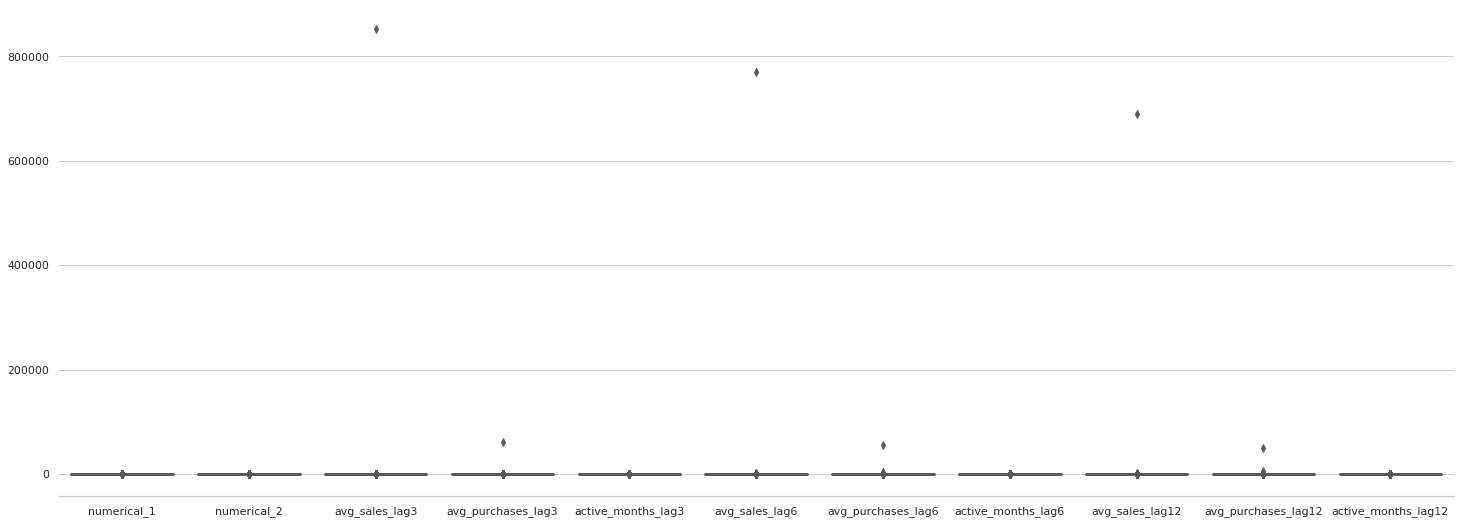

In [ ]:
#LPS &OSR: Se gráfican las distribuciónes de las variables númericas. 
data= merchants[numeric_features]

import seaborn as sns 

sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid") 
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) 
sns.despine(left=True)

Con respecto al gráfico anterior se puede evidenciar inicialmente presencia de datos atípicos en las variables: **avg_sales_lag3, avg_purchases_lag3, avg_sales_lag6, avg_sales_lag12 y avg_purchases_lag12**

Las demas variables en el gráfico se evidencian con distribuciones menos dispersas a las variables anteriormente mensionadas.

In [ ]:
#LPS& OSR: Estas lineas de código estancian y ajusta el algortimo LocalOutLiarFactor
#LPS &OSR: Se realia un iterador que evalua el n_neighbor que detecte la mayor cantidad de outliers
from sklearn.neighbors import LocalOutlierFactor # detección de outlers no supervisado basado en LOF
from matplotlib import pyplot # Librería para hacer gráficas
Resultado =[]

for i in range(3,12,2):
  LOF = LocalOutlierFactor(n_neighbors = i, algorithm = 'auto', metric = 'euclidean')
  Filtrado = LOF.fit_predict(merchants[numeric_features]) # Se realiza la predicción de los datos atípicos
  NOF = LOF.negative_outlier_factor_ # Detecta los valores positivos y negativos (residuos). Si los valores son grandes, entonces son valores no atípicos y por lo general, son valores cercanos a -1.
                                    # Si los valores son positivos y grandes y cercanos a 1, entonces son valores atípicos. La opción negative_outlier_dactor_ calcula dichos valores por 
                                    # la media de la relación entre la densidad local de una muestra y las de sus vecinos más cercanos.

  radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) # radio de detección de datos atípicos
  ground_truth = np.ones(len(merchants[numeric_features]), dtype = int) # Se recomienda para luego comparar que datos es o no atípico (genera un vector de 1 o -1)
  n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

  Resultado.append([i,n_errors])

In [ ]:
#LPS &OSR: Se crea un datafram con los resultados dela interación anterior
Vecinos= pd.DataFrame(Resultado,  columns=["Número vecinos","Muestras outliers"])
Vecinos.style.hide_index()

Número vecinos,Muestras outliers
3,2294
5,1823
7,1690
9,1662
11,1678


Teniendo en cuenta el resumen de iteraciones presentadas por el Dataframe **Vecinos**, se decide instanciar el parámetro **n_neighbor=3 **para el algoritmo LocalOutliearFactor. 

In [ ]:
#LPS& OSR: Este codigo estancia y ajusta el algortimo LocalOutLiarFactor
LOF = LocalOutlierFactor(n_neighbors = 3, algorithm = 'auto', metric = 'euclidean')
Filtrado = LOF.fit_predict(merchants[numeric_features]) # Se realiza la predicción de los datos atípicos
NOF = LOF.negative_outlier_factor_ # Detecta los valores positivos y negativos (residuos). Si los valores son grandes, entonces son valores no atípicos y por lo general, son valores cercanos a -1.
                                    # Si los valores son positivos y grandes y cercanos a 1, entonces son valores atípicos. La opción negative_outlier_dactor_ calcula dichos valores por 
                                    # la media de la relación entre la densidad local de una muestra y las de sus vecinos más cercanos.

radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) # radio de detección de datos atípicos
ground_truth = np.ones(len(merchants[numeric_features]), dtype = int) # Se recomienda para luego comparar que datos es o no atípico (genera un vector de 1 o -1)
n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

In [ ]:
#LPS & OSR: Estas lineas de codigo filtran y localizan las variables donde no hay datos atipicos
pos = np.where(Filtrado == ground_truth) # Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
merchants= merchants.loc[pos, :]

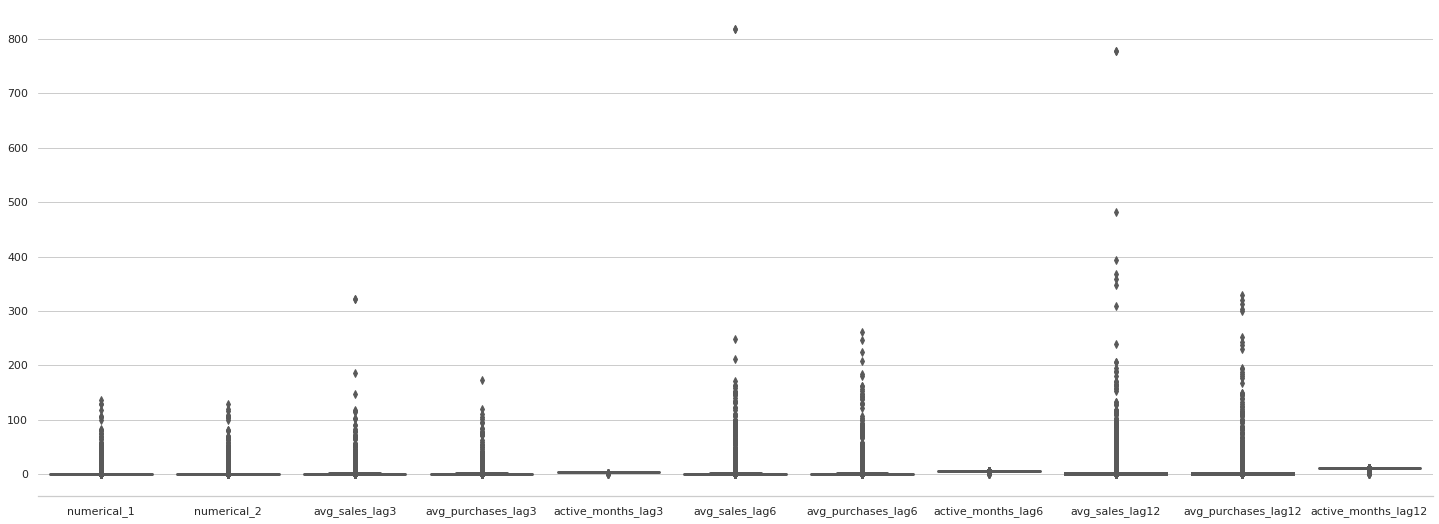

In [ ]:
#LPS &OSR: Se realiza nuevamente la visualización para verificar el comportamiento de los datos, después de la eliminación de datos atipicos. 
data= merchants[numeric_features]

import seaborn as sns # Librería de visualización para data science

sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

In [ ]:
#LPS &OSR: Se reemplazan los valores infinitos por cero. 
merchants['avg_purchases_lag3'].replace(np.inf, 0)
merchants['avg_purchases_lag6'].replace(np.inf, 0)
merchants['avg_purchases_lag12'].replace(np.inf, 0)

3        13.250000
4         0.666667
5         0.997021
6         1.000000
7         4.272727
           ...    
62435     1.024796
62436     0.606765
62437     0.750763
62438     0.584000
62439     0.540334
Name: avg_purchases_lag12, Length: 60146, dtype: float64

### **Procesamiento de datos**

 **Selección de Merchant_ID**

Debido que el dataset contiene **Merchants_id** duplicados se crea una agrupación por la variable merchant_id obtener marchants_id unicos. 

In [ ]:
#LPS &OSR: Se realiza un groupby del dataset merchants agrupando con las siguientes estrategias: 
# para las variables cuantitativas se emplea la mediana como estrategía de agrupación.
#Para la variable cualitativa se emplea la moda como estrategía de agrupación. 

merchants_group_by= merchants.groupby('merchant_id', as_index=False).agg( {'merchant_group_id':lambda x: stats.mode(x)[0][0], \
                                                 'merchant_category_id':lambda x: stats.mode(x)[0][0], \
                                                  'subsector_id':lambda x: stats.mode(x)[0][0] ,\
                                                  'numerical_1':(np.median), \
                                                  'numerical_2':(np.median),\
                                                 'category_1':lambda x: stats.mode(x)[0][0], \
                                                  'most_recent_sales_range':lambda x: stats.mode(x)[0][0] ,\
                                                  'most_recent_purchases_range':lambda x: stats.mode(x)[0][0], \
                                                  'avg_sales_lag3':(np.median) ,\
                                                  'avg_purchases_lag3':(np.median), \
                                                  'active_months_lag3':(np.median),\
                                                  'avg_sales_lag6':(np.median) ,\
                                                  'avg_purchases_lag6':(np.median), \
                                                  'active_months_lag6':(np.median),\
                                                  'active_months_lag6':(np.median), \
                                                  'avg_purchases_lag12':(np.median), \
                                                  'active_months_lag12':(np.median),\
                                                  'active_months_lag12':(np.median), \
                                                  'category_4':lambda x: stats.mode(x)[0][0] ,\
                                                  'city_id':lambda x: stats.mode(x)[0][0], \
                                                  'state_id':lambda x: stats.mode(x)[0][0], \
                                                  'category_2':lambda x: stats.mode(x)[0][0]})                                                  

Ya que muchas de las características contenidas en el conjunto de datos **Merchants** estan agrupadas en rango muy amplio de etiquetas, se decide realizar una reclasificación de los valores de las etiquetas para tener como máximo 4 etiquetas por característica. Los rangos en los cuales fueron divididas las características estan asociados a sus percentiles. 

In [ ]:
#LPS &OSR: Se realiza el agrupamiento de las caracteristicas a través de una función lamba creada  y aplicada posteriormente a cada caracteristica. 
f = lambda x: 0 if x<222 else 1 if x<373 else  2 if x<683 else 3 
merchants_group_by['merchant_category_id'] =merchants_group_by['merchant_category_id'].map(f)

f = lambda x: 0 if x<19 else 1 if x<27 else  2 if x<33 else 3 
merchants_group_by['subsector_id'] =merchants_group_by['subsector_id'].map(f)

f = lambda x: 0 if x<1 else 1 if x<69 else  2 if x<182 else 3 
merchants_group_by['city_id'] =merchants_group_by['city_id'].map(f)

f = lambda x: 0 if x<10 else 1 if x<16 else  2 
merchants_group_by['state_id'] =merchants_group_by['state_id'].map(f)


In [ ]:
# LPS & OSR Se realiza un casting para con el objetivo de asignar el tipo de dato object y category a las variables correspondientes. 
merchants_group_by['merchant_id']= merchants_group_by['merchant_id'].astype('object')
merchants_group_by['merchant_group_id']= merchants_group_by['merchant_group_id'].astype('category')
merchants_group_by['merchant_category_id']= merchants_group_by['merchant_category_id'].astype('category')
merchants_group_by['subsector_id']= merchants_group_by['subsector_id'].astype('category')
merchants_group_by['category_1']= merchants_group_by['category_1'].astype('category')
merchants_group_by['most_recent_sales_range']= merchants_group_by['most_recent_sales_range'].astype('category')
merchants_group_by['most_recent_purchases_range']= merchants_group_by['most_recent_purchases_range'].astype('category')
merchants_group_by['subsector_id']= merchants_group_by['subsector_id'].astype('category')
merchants_group_by['category_4']= merchants_group_by['category_4'].astype('category')
merchants_group_by['city_id']= merchants_group_by['city_id'].astype('category')
merchants_group_by['state_id']= merchants_group_by['state_id'].astype('category')
merchants_group_by['category_2']= merchants_group_by['category_2'].astype('category')

In [ ]:
#LPS & OSR: se verifica que las variables esten con el data-type correcto. 
merchants_group_by.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60114 entries, 0 to 60113
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   merchant_id                  60114 non-null  object  
 1   merchant_group_id            60114 non-null  category
 2   merchant_category_id         60114 non-null  category
 3   subsector_id                 60114 non-null  category
 4   numerical_1                  60114 non-null  float64 
 5   numerical_2                  60114 non-null  float64 
 6   category_1                   60114 non-null  category
 7   most_recent_sales_range      60114 non-null  category
 8   most_recent_purchases_range  60114 non-null  category
 9   avg_sales_lag3               60114 non-null  float64 
 10  avg_purchases_lag3           60114 non-null  float64 
 11  active_months_lag3           60114 non-null  float64 
 12  avg_sales_lag6               60114 non-null  float64 
 13  a

**Preparación de los datos**

Dado que se realizará posteriormente un proceso de creación de Cluster, en esta etapa se realizará la preparación de los datos, que consiste en la aplicación de un Pipeline que ejecuta dos pasos: 

1. Imputación y estandarización de variables cuantitativas.
2. Imputación y un labol encoding para las variables cualitativas. 

In [ ]:
#LPS &OSR: Se clasifican en una lista las variables cuantitivas y en otra las variables cualitativas. 
numeric_features = merchants_group_by.select_dtypes(include=['float64', 'int']).columns.to_list()
categorical_features = merchants_group_by.select_dtypes(include='category').columns.to_list()

In [ ]:
#LPS& OSR: Se realiza una función que elimina los nan, y los valores marcados como inf del dataset
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [ ]:
#LPS &OSR: Se aplica la función anterior en el dataset
merchants_DF=clean_dataset(merchants_group_by)

In [ ]:
#LPS&OSR: Se realiza una copia del dataset Merchant_DF
merchants_DF_V2=merchants_DF.copy()

In [ ]:
#LPS&OSR: Se eliminan las variables merchant_group_id y merchant_id
merchants_DF_V2.drop(columns=['merchant_group_id','merchant_id'] ,inplace=True)

In [ ]:
#LPS & OSR = Se agrupan en una listas las variables cuantitativa y en otra lista las variables cualitativas del dataset merchants_DF_V2
numeric_features = merchants_DF_V2.select_dtypes(include=['float64', 'int']).columns.to_list()
categorical_features = merchants_DF_V2.select_dtypes(include=['category']).columns.to_list()

In [ ]:
#LPS & OSR: Este codigo realiza un pipiline que contiene los siguientes pasos: 
# Para las variables númericas realiza una imputación de los datos con el estadistico mediana
# Para las variables categoricas se realiza una imputación de los datos con el estadistico moda. 
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])


preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
#LPS &OSR: Se asigna el pipiline a el dataset merchants_DF_V2
pipe = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS &OSR: Se ajusta el pipiline al dataset merchants_DF_V2
pipe.fit(merchants_DF)
preprocessed_data = pipe["preprocessor"].transform(merchants_DF) # se realiza la transformación de los datos. 
preprocessed_data 

array([[-0.12088458, -0.11800795,  0.0623914 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12088458, -0.11800795, -0.06554967, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12088458, -0.11800795, -0.09113788, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.12088458, -0.11800795, -0.16790252, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09743906, -0.09415697, -0.07407907, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12088458, -0.11800795, -0.07407907, ...,  1.        ,
         0.        ,  0.        ]])

## **2. Creación de Clusters**

En esta sesión se desarrollará la creación de Cluster del dataset **Merchants**, con el objetivo de  agrupar los **merchant_id** con características similares para identificar grupos.

La metodología que se va usar es la siguiente: 

Creación de clusters por medio del **método Kmeans**, evaluando el parámetro *n_clusters* con los siguientes métodos: 

* Metodo del codo.
* Davies bouldin
* Silueta

Creación de clusters por medio del **método GMM,** evaluando el parámetro *n_clusters* con los siguientes métodos: 

* Davies bouldin
* AIC BIC




### **2.1 Creación de Cluster empleando el modelo Kmeans**

#### **2.1.1 Selección del n_clusters por el método del codo**

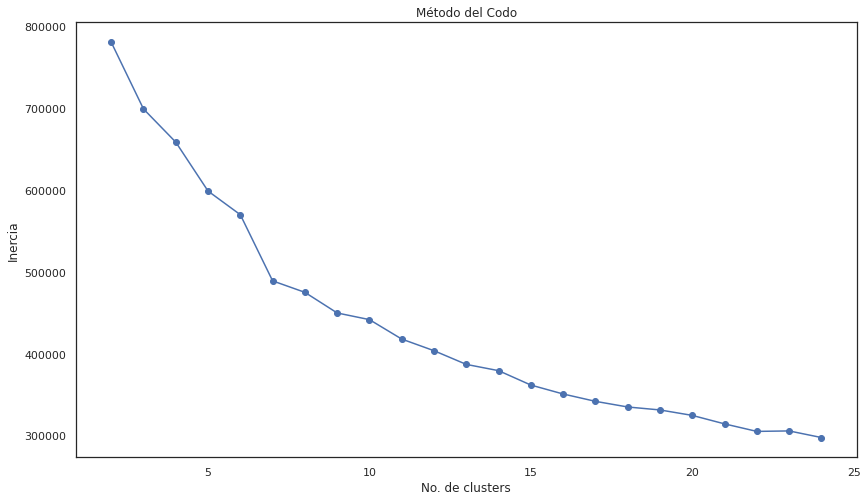

In [ ]:
#LPSR &OSR: Se hace iteraciones del modelo K means guardando los valores de inercia para cada número de cluster
#LPS &OSR: Adicionalmente durante las iteraciones se evalua el score davies_bouldin_score. 

from sklearn.metrics import davies_bouldin_score
DB_score_kmeans=pd.DataFrame()
inercia = []
DB_score=[]
idx=0
for i in range(2, 25):

    algoritmo = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    algoritmo.fit(preprocessed_data)
    
    inercia.append(algoritmo.inertia_)

    DB= davies_bouldin_score(preprocessed_data,algoritmo.labels_)
    #DB_score.append(DB)

    DB_score_kmeans.loc[idx, 'Cluster']=i
    DB_score_kmeans.loc[idx, 'davies_bouldin_score']=DB

    idx+=1
        
#LPS &OSR: Se traza la curva de la suma de errores cuadráticos 
plt.figure(figsize=[14,8])
sns.set_style("white")
plt.title('Método del Codo')
plt.xlabel('No. de clusters')
plt.ylabel('Inercia')
plt.plot(list(range(2, 25)), inercia, marker='o')
plt.show()

Al analizar las gráfica del método del codo, se puede concluir que el valor de la inercia no varia significativamente a partir 8 clusters, ya que el valor de la pendiente tiende a disminuir, es decir, la varianza intra-cluster disminuye. 

.

#### **2.1.2 Selección de n_clusters por método de Davis Bouldin Score**

In [ ]:
#LPS se imprime el dataframe creado de las iteacciones de los k .
DB_score_kmeans.sort_values(by='davies_bouldin_score', ascending=True).head(2)

,Cluster,davies_bouldin_score
0,2.0,0.726511
1,3.0,0.772651


Text(0, 0.5, 'Score')

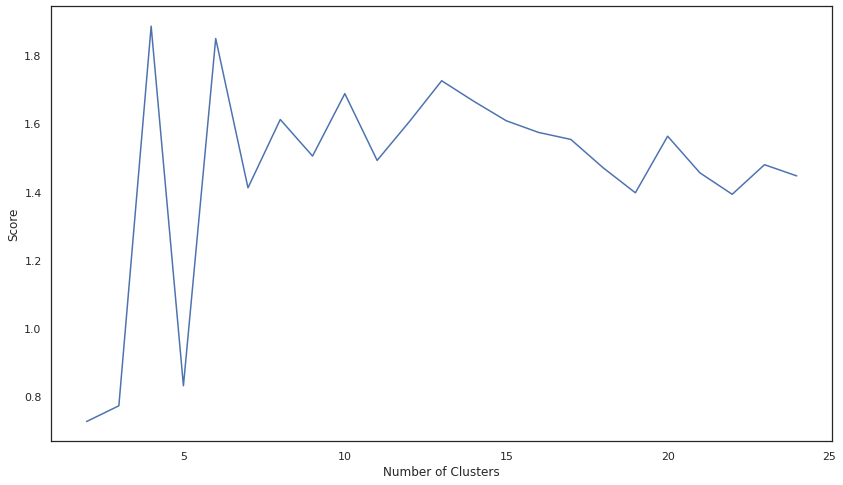

In [ ]:
#LPS &OSR: Se imprime el gráfico de lineas con los puntajes obtenidos evaluando el kmeans con David_bouldin_Score con las iteraciones de k means
plt.figure(figsize=(14,8))
sns.set_style("white")
sns.lineplot(data=DB_score_kmeans, x="Cluster", y="davies_bouldin_score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")

De acuerdo con el gráfico se puede evicenciar que el score más bajo se puede apreciar en K=3, a partir de k=4 en adelante los scores fluctuan en un rango similar y con puntajes muy altos. 

#### **2.1.3 Selección de n_clusters por método de Silueta**

Text(0, 0.5, 'Media índices silhouette')

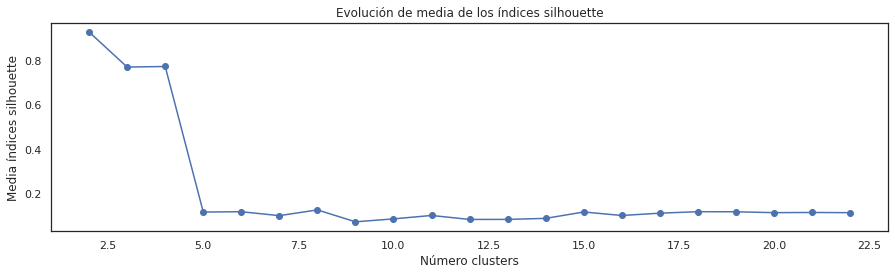

In [ ]:

# Método silhouette para identificar el número óptimo de cluste
range_n_clusters = range(2, 23)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        #n_init       = 20, 
                        random_state = 10
                    )
    cluster_labels = modelo_kmeans.fit_predict(preprocessed_data )
    silhouette_avg = silhouette_score(preprocessed_data , cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(15, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')


A partir del gráfico se puede concluir que con un k=2 se puede encontrar el maximo de la silueta, es decir, que con éste número de cluster la separación de los cluster obtiene mejor calidad.

#### **Creación de Clusters con  Kmeans instanciando los n_cluster óptimos**

**Kmeans inertia: K=8**

In [ ]:
#LPS &OSR: Se instancia el modelo Kmeans con K=8 clusters 
#LPS&OSR: se ajusta el modelo y se almacena en la variable algotrmo los resultados
#LPS&OSR :Se crea la columna Cluster con la clasificación entregada por el modelo.
k=8
model = KMeans(n_clusters=k, random_state=27)
model.fit(preprocessed_data)
algoritmo = model.predict(preprocessed_data)
merchants_DF['Cluster'] =algoritmo

In [ ]:
#LPS&OSR: Se Crea un dataframe con los merchants_id y los cluster obtenidos
DF_Merchants_Kmeans=merchants_DF[['merchant_id','Cluster']]
DF_Merchants_Kmeans.to_csv("DF_Merchants_Kmeans_k8_Entropia.csv")
files.download("DF_Merchants_Kmeans_k8_Entropia.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Kmeans DB_score: K=3**

In [ ]:
#LPS &OSR: Se instancia el modelo Kmeans con K=3 clusters 
#LPS&OSR: se ajusta el modelo y se almacena en la variable algotrmo los resultados
#LPS&OSR :Se crea la columna Cluster con la clasificación entregada por el modelo.
k=3
model_k3 = KMeans(n_clusters=k, random_state=27)
model_k3.fit(preprocessed_data)
algoritmo_k3 = model_k3.predict(preprocessed_data)
merchants_DF['Cluster_k3_DB'] =algoritmo_k3

In [ ]:
#LPS&OSR: Se Crea un dataframe con los merchants_id y los cluster obtenidos
DF_Merchants_Kmeans_k3_DB=merchants_DF[['merchant_id','Cluster_k3_DB']]
DF_Merchants_Kmeans_k3_DB.to_csv("DF_Merchants_Kmeans_k3_DB.csv")
files.download('DF_Merchants_Kmeans_k3_DB.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Kmeans Silouette: K=2**

In [ ]:
#LPS &OSR: Se instancia el modelo Kmeans con K=2 clusters 
#LPS&OSR: se ajusta el modelo y se almacena en la variable algotrmo los resultados
#LPS&OSR :Se crea la columna Cluster con la clasificación entregada por el modelo.
k=2
model_k2 = KMeans(n_clusters=k, random_state=27)
model_k2.fit(preprocessed_data)
algoritmo_k2 = model_k2.predict(preprocessed_data)
merchants_DF['Cluster_k2_SLH'] =algoritmo_k2

In [ ]:
#LPS&OSR: Se Crea un dataframe con los merchants_id y los cluster obtenidos y se guarda en un cvs
DF_Merchants_Kmeans_k2_SLH=merchants_DF[['merchant_id','Cluster_k2_SLH']]
DF_Merchants_Kmeans_k2_SLH.to_csv("DF_Merchants_Kmeans_k2_SLH.csv")
files.download('DF_Merchants_Kmeans_k2_SLH.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **2.2 Selección del K por el método de GMM-EM**

##### **2.2.1 Selección de n_components por los métodos AIC y BIC**

In [ ]:
#https://cmdlinetips.com/2021/03/gaussian-mixture-models-with-scikit-learn-in-python/
#LPS &OSR: Se hace iteraciones de 2 hasta 25 componentes
#LPS&OSR: se ajusta el modelo en cada intereción y se guardan lso valores obtenidos
from sklearn.mixture import GaussianMixture
n_components = np.arange(2, 25)
models = [GaussianMixture(n, 
                          covariance_type='full', random_state=0).fit(preprocessed_data) for n in n_components]

In [ ]:
#LPS &OSR se evalua el número de cluster con las medidas de comparación Akaike information criterion y Bayesian information criterion
gmm_model_comparisons=pd.DataFrame({"n_components" : n_components,
                                  "BIC" : [m.bic(preprocessed_data) for m in models],
                                   "AIC" : [m.aic(preprocessed_data) for m in models]})

Text(0, 0.5, 'Score')

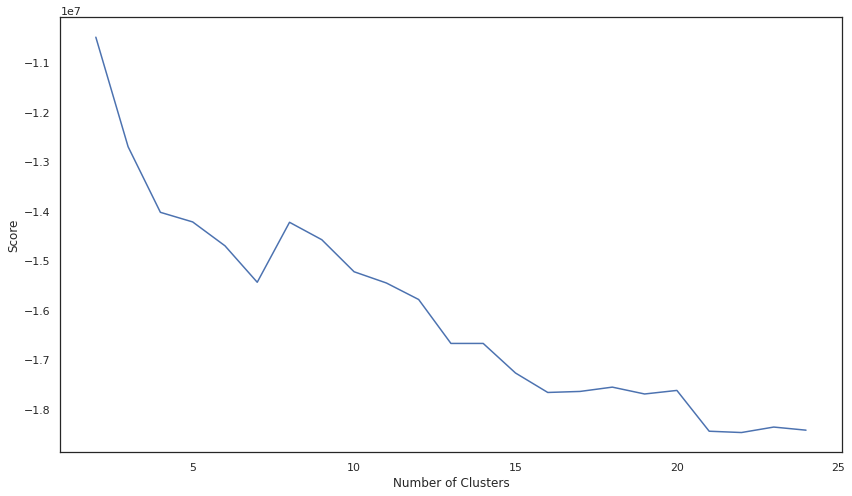

In [ ]:
plt.figure(figsize=(14,8))
sns.set_style("white")
sns.lineplot(data=gmm_model_comparisons, x='n_components', y="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")

Se puede observar que el score mas bajo obtenido empleando la medida de comparación AIC es de 22  componentes, a partir de ese punto la caida de los puntajes tiende a estabilizarse.

Text(0, 0.5, 'Score')

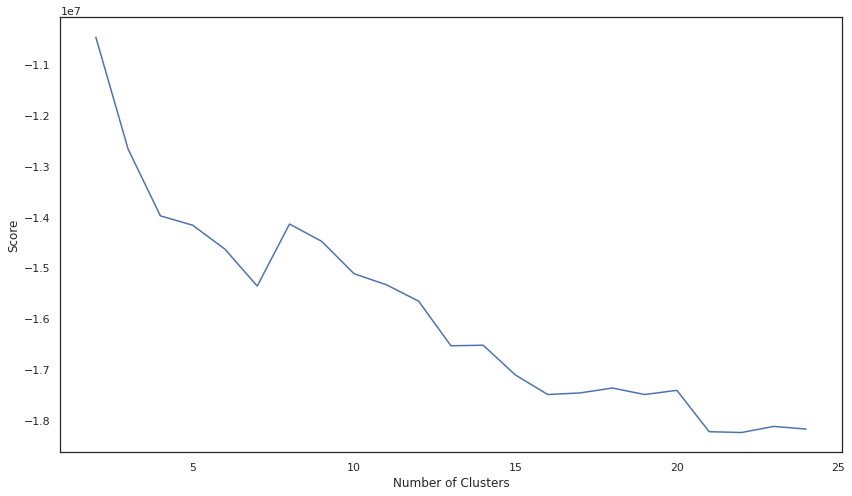

In [ ]:
plt.figure(figsize=(14,8))
sns.set_style("white")
sns.lineplot(data=gmm_model_comparisons, x='n_components', y="BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")

Se puede observar que el score mas bajo obtenido empleando la medida de comparación BIC es de 22  componentes, a partir de ese punto la caida de los puntajes tiende a estabilizarse.

#### **2.2.2 Selección de n_components por el método Davies Bouldin Score**

In [ ]:
from sklearn.metrics import davies_bouldin_score
#LPS&OSR:  se hacen iteraciones de los modelos GMM calculando la metrica de davies_bouldin_score y guardandola en un dataframe
# Davies_bouldin_score: Zero is the lowest possible score. Values closer to zero indicate a better partition.

gmm_model_comparisons_davies_bouldin_score=pd.DataFrame({"n_components" : n_components,
                                                          "davies_bouldin_score" : [davies_bouldin_score(preprocessed_data,m.predict(preprocessed_data)) for m in models]})

In [ ]:
#LPS &OSR:  Se imprime el resultado en orden ascendente del valor más bajo obtendio en la iteración.
gmm_model_comparisons_davies_bouldin_score.sort_values(by='davies_bouldin_score', ascending=True).head(1)

,n_components,davies_bouldin_score
16,18,2.10797


De las iteraciones resultantes se puede apreciar que el modelo que obtuvo menor puntaje en la métrica davies_bouldin_score fue el modelo instanciado con n_components=18.

In [ ]:
#LPS&OSR: Se corroboran los resultados de la metrica AIC
gmm_model_comparisons.sort_values(by='AIC', ascending=True).head(1)

,n_components,BIC,AIC
20,22,-1.824790e+07,-1.847134e+07


In [ ]:
#LPS&OSR: Se corroboram los resultados de la metrica BIC
gmm_model_comparisons.sort_values(by='BIC', ascending=True).head(1)

,n_components,BIC,AIC
20,22,-1.824790e+07,-1.847134e+07


#### **Creación de Clusters con  GMM-EM instanciando los n_components óptimos**

**DB_score: K=18**

In [ ]:
#LPS &OSR: Se instancia el modelo GMM-EM con n=18 clusters 
#LPS&OSR: se ajusta el modelo y se almacena en la variable algotrmo los resultados
#LPS&OSR :Se crea la columna Cluster con la clasificación entregada por el modelo.
#LPS&OSR: Se Crea un dataframe con los merchants_id y los cluster obtenidos y se guarda en un cvs

n=18
gmm = GaussianMixture(n, covariance_type='full', random_state=0).fit(preprocessed_data)
labels_algoritmo_k18_GMM_DB = gmm.predict(preprocessed_data)
merchants_DF['Cluster_k18_GMM_DB'] =labels_algoritmo_k18_GMM_DB
DF_Merchants_GMM_k18_DB=merchants_DF[['merchant_id','Cluster_k18_GMM_DB']]
DF_Merchants_GMM_k18_DB.to_csv("DF_Merchants_GMM_k18_DB.csv")
files.download('DF_Merchants_GMM_k18_DB.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**AIC_BIC: K=22**

In [ ]:
#LPS &OSR: Se instancia el modelo GMM-EM con n=22 clusters 
#LPS&OSR: se ajusta el modelo y se almacena en la variable algotrmo los resultados
#LPS&OSR :Se crea la columna Cluster con la clasificación entregada por el modelo.
#LPS&OSR: Se Crea un dataframe con los merchants_id y los cluster obtenidos y se guarda en un cvs

n=22
gmm = GaussianMixture(n, covariance_type='full', random_state=0).fit(preprocessed_data)
labels_algoritmo_k22_GMM_AIC_BIC = gmm.predict(preprocessed_data)
merchants_DF['Cluster_k22_GMM_AIC_BIC'] =labels_algoritmo_k22_GMM_AIC_BIC
DF_Merchants_GMM_k22_AIC_BIC=merchants_DF[['merchant_id','Cluster_k22_GMM_AIC_BIC']]
DF_Merchants_GMM_k22_AIC_BIC.to_csv("DF_Merchants_GMM_k22_AIC_BIC.csv")
files.download('DF_Merchants_GMM_k22_AIC_BIC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Como resultado de este notebook se obtienen los siguientes archivos: 

**DF_Merchants_GMM_k18_DB.csv:** contiene los clusters creados por el método GMM_EM, ejecutado con 18 n_components.

**DF_Merchants_GMM_k22_AIC_BIC.csv:**  esta compuesto pro los cluster creados por el metodo GMM_EM, ejecutado con 22 n_components.

**DF_Merchants_Kmeans_k2_SLH.csv:**: contiene los clusters creados por el método Kmeans, teniendo 2 n_cluster.

**DF_Merchants_Kmeans_k3_DB.csv**: contiene los clusters creados por el método Kmeans, teniendo 3 n_cluster.

**DF_Merchants_Kmeans_k8_Entropia.csv: ** contiene los clusters creados por el método Kmeans, teniendo 3 n_cluster.



